In [115]:
import os
import difflib
import esda
import contextily
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pysal.lib import weights

In [5]:
data = pd.read_csv('../data/info_per_district_and_meters.csv')

In [6]:
district_dict = pd.read_csv('../data/average_metrics.csv')
district_dict = district_dict[['distrito', 'tipo']].set_index('distrito')['tipo'].to_dict()

<Axes: >

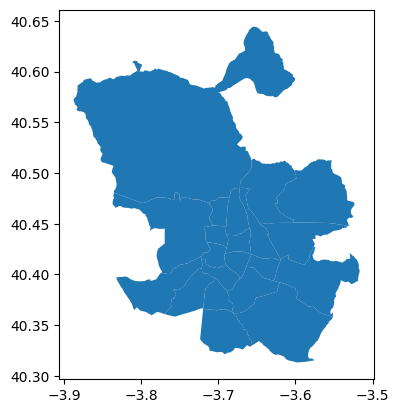

In [7]:
# Load polygons from Madrid center

polygons_center = gpd.read_file('../data/madrid-districts.geojson')
polygons_center = polygons_center[['name', 'geometry']]
polygons_center.plot()

In [8]:
municipios = gpd.read_file('../data/Municipios_-3498985394491007638.geojson')
municipios.head()

OBJECTID                 INSPIREID      NATCODE               NAMEUNIT  \
0         1  ES.IGN.SIGLIM34081616266  34081616266  Villarejo-Periesteban   
1         2  ES.IGN.SIGLIM34081616269  34081616269       Villares del Saz   
2         3  ES.IGN.SIGLIM34081616270  34081616270            Villarrubio   
3         4  ES.IGN.SIGLIM34081616271  34081616271               Villarta   
4         5  ES.IGN.SIGLIM34081616272  34081616272   Villas de la Ventosa   

  CODNUT1 CODNUT2 CODNUT3 CODIGOINE  \
0     ES4    ES42   ES423     16266   
1     ES4    ES42   ES423     16269   
2     ES4    ES42   ES423     16270   
3     ES4    ES42   ES423     16271   
4     ES4    ES42   ES423     16272   

                                            geometry  
0  POLYGON ((-2.47791 39.88027, -2.47793 39.88074...  
1  POLYGON ((-2.58669 39.85793, -2.58601 39.85842...  
2  POLYGON ((-2.96423 39.95773, -2.96231 39.95816...  
3  POLYGON ((-1.68041 39.46783, -1.67391 39.46654...  
4  POLYGON ((-2.49911 40.26601, -2.49878 40.26597...

### Search for Madrid code

In [9]:
municipios[municipios['NAMEUNIT'] == 'Madrid']

OBJECTID                 INSPIREID      NATCODE NAMEUNIT CODNUT1 CODNUT2  \
472       473  ES.IGN.SIGLIM34132828079  34132828079   Madrid     ES3    ES30   

    CODNUT3 CODIGOINE                                           geometry  
472   ES300     28079  POLYGON ((-3.88558 40.57446, -3.88522 40.57522...

### Filter out polygons from madrid

In [ ]:
madrid = municipios[municipios['CODNUT3'] == 'ES300']
madrid = madrid[['NAMEUNIT', 'geometry']].copy()
madrid.rename(columns={'NAMEUNIT': 'name'}, inplace=True)

polygons = pd.concat([madrid, polygons_center]).set_index('name')

### Map polygons name with our district names

In [55]:
def find_most_similar(target, candidates):
    best_match = difflib.get_close_matches(target, candidates, n=1, cutoff=0.0)
    if best_match:
        return best_match[0]
    else:
        return None


districts = list(district_dict.keys())

chosen_districts = {}
for d in districts:
    sim = find_most_similar(d, polygons.index)
    chosen_districts[sim] = d

In [155]:
aux = polygons[polygons.index.isin(chosen_districts)]
aux = aux.reset_index()
aux['distrito'] = aux['name'].apply(lambda x: chosen_districts[x])
aux = aux.drop('name', axis=1)

aux = aux.to_crs(epsg=3857)

aux.explore()

### Spatial lag
1. RB
2. Revalorization

In [168]:
data_split = data[['distrito', 'RB', 'PER', 'revaluation']].groupby('distrito').agg(
    {'RB': 'mean', 'PER': 'mean', 'revaluation': 'mean'}).reset_index()
df = gpd.GeoDataFrame(pd.merge(data_split, aux, on='distrito'))

In [169]:
w = weights.Queen.from_dataframe(df, idVariable='distrito')
w.transform = 'R'
w['retiro'] # neighbours

('WARNING: ', 'aranjuez', ' is an island (no neighbors)')
('WARNING: ', 'coslada', ' is an island (no neighbors)')
('WARNING: ', 'tres-cantos', ' is an island (no neighbors)')


/tmp/ipykernel_8891/1576811970.py:1: FutureWarning:

`idVariable` is deprecated and will be removed in future. Use `ids` instead.

/home/pdb/.local/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning:

The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 3 islands with ids: aranjuez, coslada, tres-cantos.



{'arganda': 0.16666666666666666,
 'moratalaz': 0.16666666666666666,
 'puente-de-vallecas': 0.16666666666666666,
 'barrio-de-salamanca': 0.16666666666666666,
 'centro': 0.16666666666666666,
 'ciudad-lineal': 0.16666666666666666}

In [171]:
def get_spatial_lag(df, name):
    # Standarize from 0 to 1
    df[f'{name}_std'] = (df[name] - df[name].mean()) / df[name].std()
    df[f'w_{name}_std'] = weights.lag_spatial(w, df[f'{name}_std'])
    mi = esda.Moran(df[f'{name}_std'], w)
    print(name, mi.I)
    df = df.drop(f'{name}_std', axis=1)

In [173]:
for name in ['RB', 'PER', 'revaluation']:
    get_spatial_lag(df, name)
    df.explore(column=f'w_{name}_std', cmap='viridis')

RB 0.06335668407489821
PER 0.36417836087028976
revaluation 0.06579272108034907


## 

In [174]:
df.explore(column='w_RB_std', cmap='viridis')

## PER number of years to recover the investment

In [179]:
df.explore(column='w_PER_std', cmap='viridis')